In [1]:
import torch
from torch.utils.data import DataLoader
import numpy as np
from utils import EnhancerDataset, split_dataset, train_model, regression_model_plot
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
import torch.nn.modules.activation as activation
import sys
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
import interpretation
import seaborn as sns
import matplotlib.pyplot as plt
import tools
import logomaker
import os
import pickle

sys.path.append('../model')  
from model import ConvNetDeep, DanQ, ExplaiNN,ConvNetDeep2, ExplaiNN2, ExplaiNN3

### Train Model

In [7]:
# Directory to save the result
seed = 42 
batch = 322
num_cnns = 140
learning_rate= 8e-5

df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')

#train, test = split_dataset(df, split_type='fragment', key= 0, seed = 42)
train, test = split_dataset(df, split_type='random', cutoff = 0.8, seed = seed)

# Process datasets
train = EnhancerDataset(train, label_mode='G+', scale_mode = 'none')
test = EnhancerDataset(test, label_mode='G+', scale_mode = 'none')

# DataLoader setup
train_loader = DataLoader(dataset=train, batch_size=batch, shuffle=True)
test_loader = DataLoader(dataset=test, batch_size=batch, shuffle=True)

#input_model = ExplaiNN2(num_cnns = 256, input_length = 608, num_classes = 2, 
#                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
#                 fc_filter1 = 20, fc_filter2 = 1, drop_out = 0.3, weight_path = None)# Training

input_model = ExplaiNN3(num_cnns = 100, input_length = 608, num_classes = 1, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

_, _, model, train_losses_by_batch, test_losses_by_batch, results, best_pearson_epoch, best_r2_epoch, device  = train_model(input_model, train_loader, test_loader, num_epochs=200, 
                                                                                         batch_size=batch, learning_rate=learning_rate, 
                                                                                         criteria='mse',optimizer_type = "adam", patience=15, 
                                                                                         seed = seed, save_model= True, dir_path='/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_results')

Using device: cuda
Model is on device: cuda:0
Epoch 1/200, Step 1/72, Loss: 83.4912
Epoch 1/200: Train Loss: 80.1932 , Test Loss: 76.8017
------------------------Evaluation------------------------
MSE: 76.7989, RMSE: 8.7635, MAE: 8.7575
R^2: -977.9113, Pearson Correlation: 0.2477, Spearman Correlation: 0.2504
----------------------------------------------------------
Epoch 2/200, Step 1/72, Loss: 77.2862
Epoch 2/200: Train Loss: 73.7177 , Test Loss: 71.7194
------------------------Evaluation------------------------
MSE: 71.7172, RMSE: 8.4686, MAE: 8.4627
R^2: -913.1384, Pearson Correlation: 0.2728, Spearman Correlation: 0.2828
----------------------------------------------------------
Epoch 3/200, Step 1/72, Loss: 70.4769
Epoch 3/200: Train Loss: 67.5001 , Test Loss: 66.5419
------------------------Evaluation------------------------
MSE: 66.5416, RMSE: 8.1573, MAE: 8.1513
R^2: -847.1670, Pearson Correlation: 0.2682, Spearman Correlation: 0.2800
-----------------------------------------

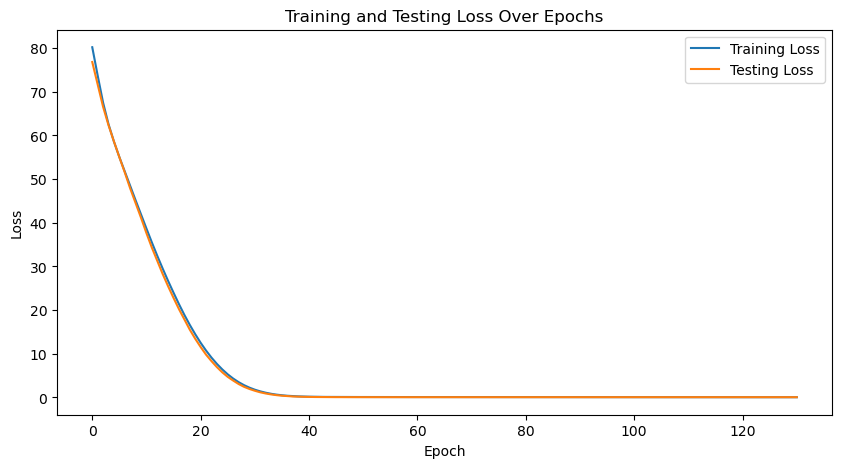

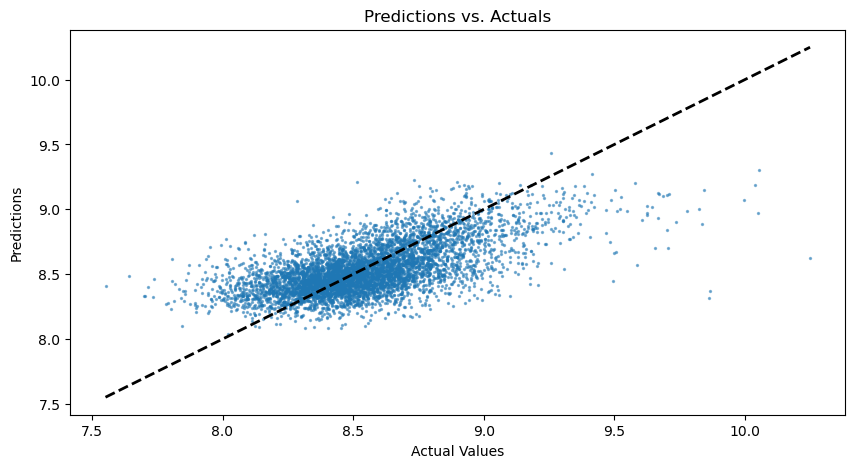

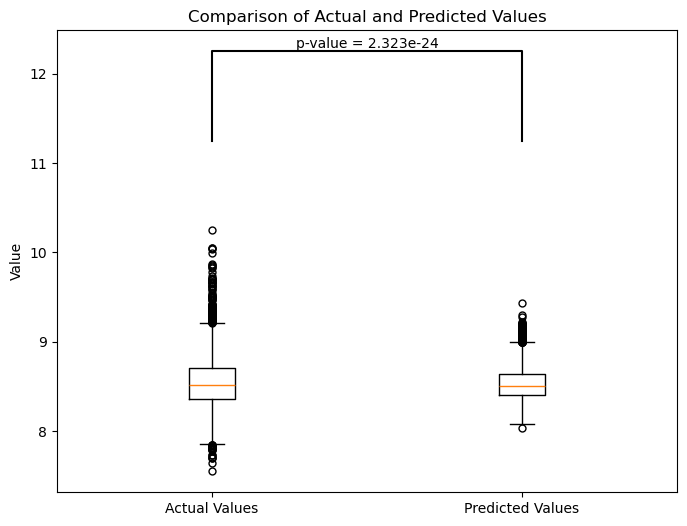

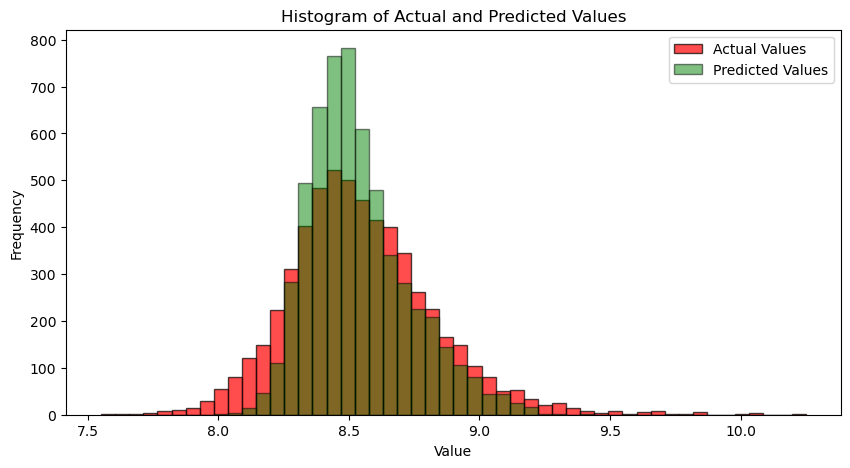

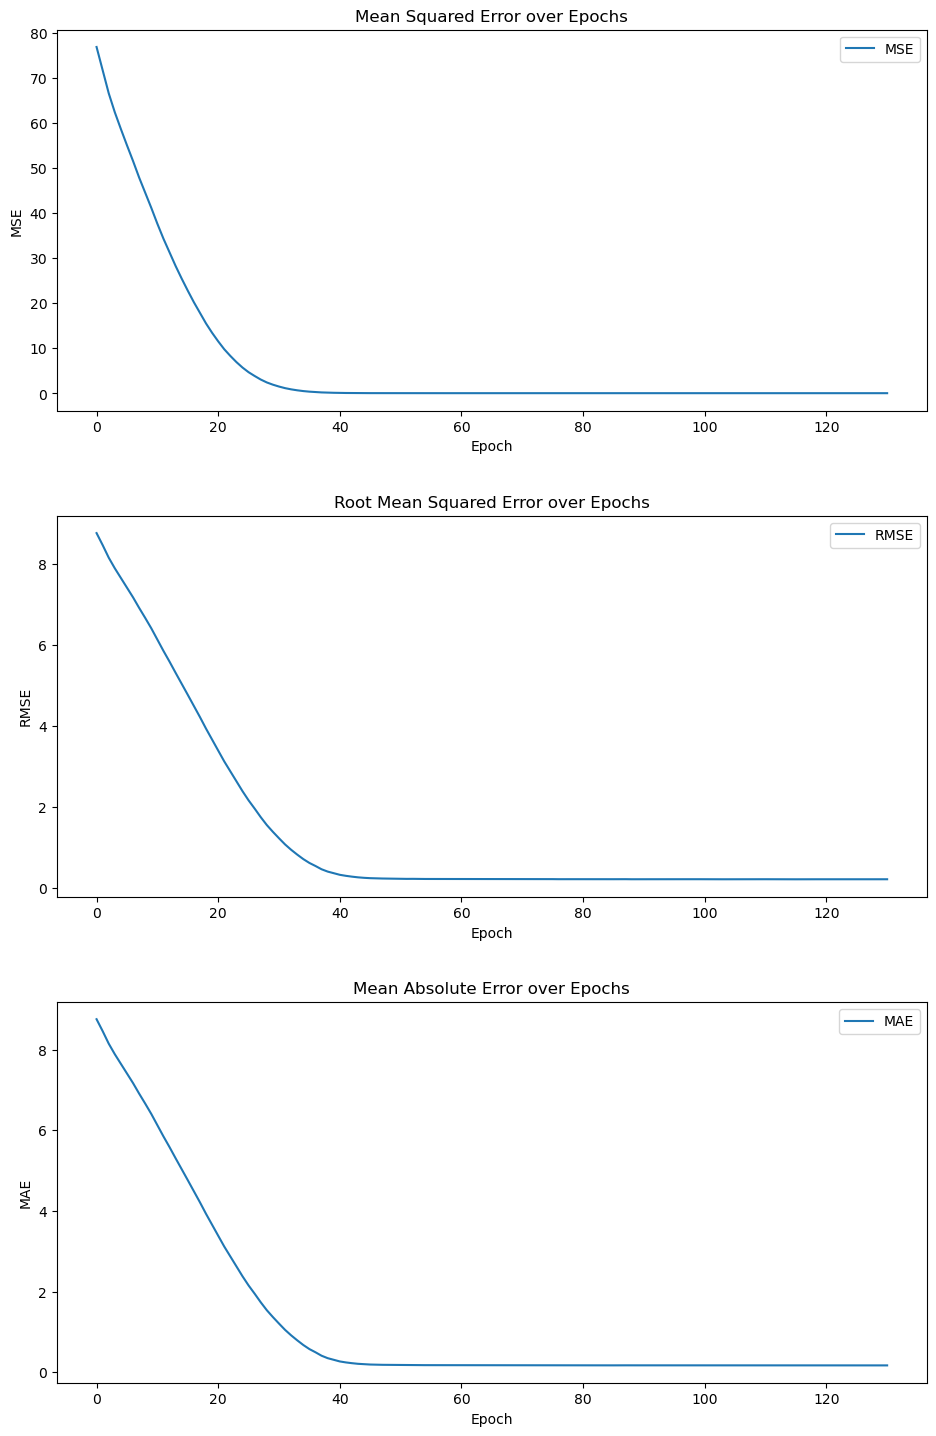

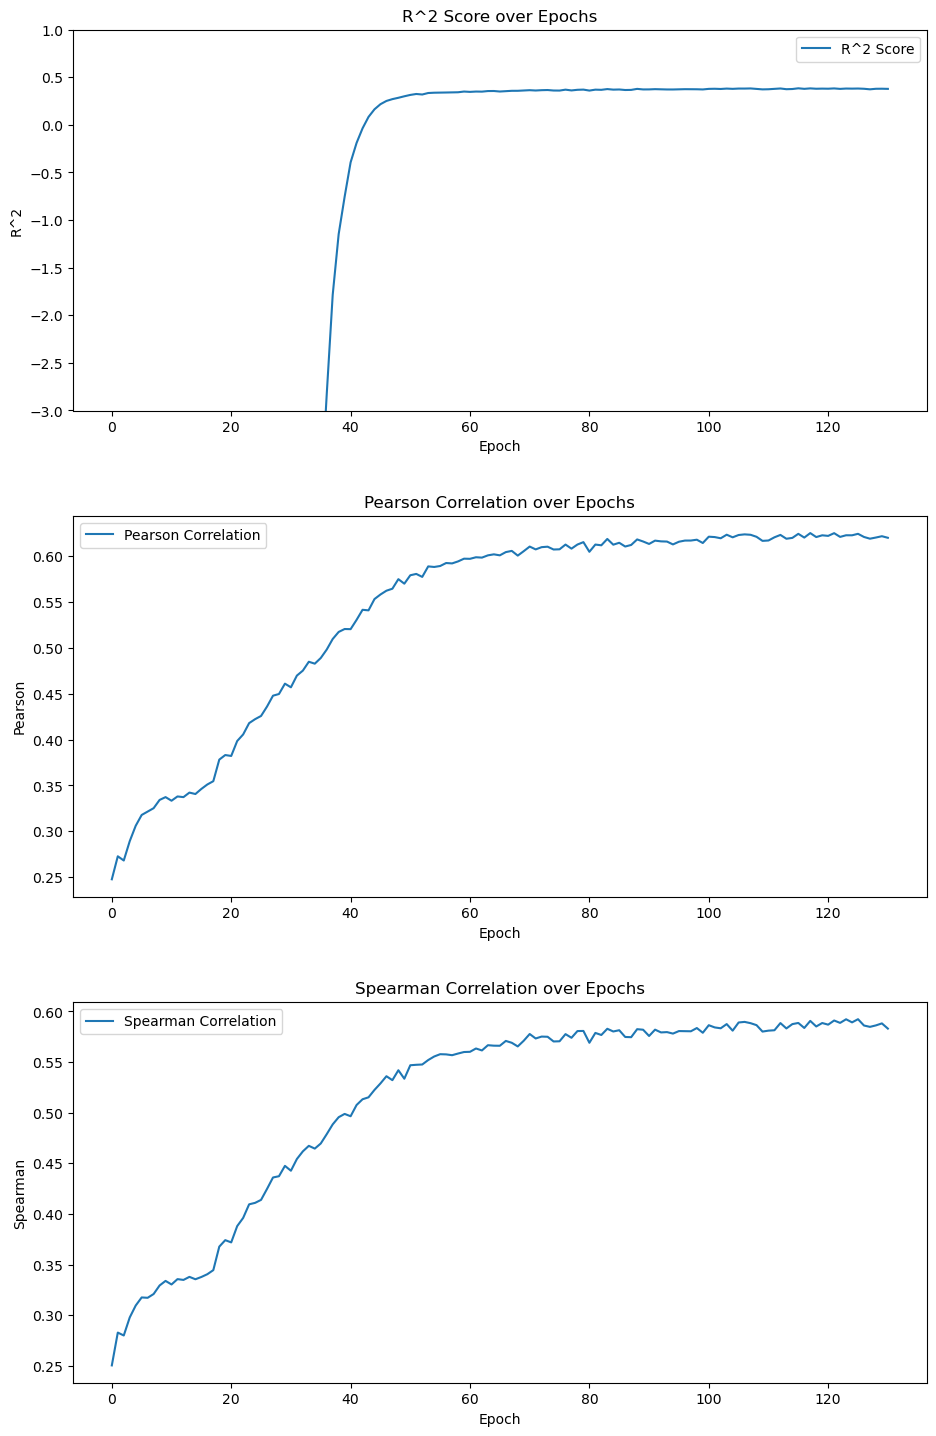

MSE: 0.0488, RMSE: 0.2209, MAE: 0.1665
R^2: 0.3782, Pearson Correlation: 0.6199, Spearman Correlation: 0.5830


In [8]:
model_path = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_results/model_epoch_{best_r2_epoch}.pth'
mse, rmse, mae, r2, pearson_corr, spearman_corr = regression_model_plot(
    model, test_loader, train_losses_by_batch, test_losses_by_batch, 
    device, results, label_mode = "G+", save_plot = False, dir_path = None, model_path = model_path)

print(f"MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")
print(f"R^2: {r2:.4f}, Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")

### Interpretation

In [2]:
best_r2_epoch = 116
filter_size = 19

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
explainn = ExplaiNN3(num_cnns = 100, input_length = 608, num_classes = 1, 
                 filter_size = filter_size, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training
explainn.to(device)  

weight_file = f'/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_results/model_epoch_{best_r2_epoch}.pth'
explainn.load_state_dict(torch.load(weight_file))
explainn.eval()

ExplaiNN3(
  (linears): Sequential(
    (0): Conv1d(400, 100, kernel_size=(19,), stride=(1,), groups=100)
    (1): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ExpActivation()
    (3): MaxPool1d(kernel_size=7, stride=7, padding=0, dilation=1, ceil_mode=False)
    (4): Flatten(start_dim=1, end_dim=-1)
    (5): Unsqueeze()
    (6): Conv1d(8400, 10000, kernel_size=(1,), stride=(1,), groups=100)
    (7): BatchNorm1d(10000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Dropout(p=0.3, inplace=False)
    (10): Conv1d(10000, 100, kernel_size=(1,), stride=(1,), groups=100)
    (11): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU()
    (13): Flatten(start_dim=1, end_dim=-1)
  )
  (final): Linear(in_features=100, out_features=1, bias=True)
)

In [2]:
# Load dataset as a pandas dataframe
df = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv')
# Prepare features and labels:
# --(Features): Transform all sequences into one-hot encodings
# --(Labels): Use GFP+ as labels
dataset = EnhancerDataset(df, label_mode='G+', scale_mode = 'none')
# Prepare dataloader
batch = 322
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)

# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)

"""Now filter out low confident predictions"""
# Calculate residuals
residuals = labels - predictions

# Calculate the upper and lower bound
upper_bound = 0.25
lower_bound = -0.25
# Create a mask for filtering out samples with low confident precition 
mask = (residuals >= lower_bound) & (residuals <= upper_bound)
mask = mask.squeeze() 

# Get sequences and labels from dataset
data_inp = []
data_out = []
# Iterate over the DataLoader
for batch_features, batch_labels in dataset:
    data_inp.append(batch_features)
    data_out.append(batch_labels)
# Concatenate all the batches into single tensors
data_inp = torch.cat(data_inp, dim=0)
data_out = torch.cat(data_out, dim=0)

# Use the mask to filter the predictions and labels
print(f'number of samples before filtering: {len(data_inp)}')
data_inp = data_inp[mask]
data_out = data_out[mask]
print(f'number of samples after filtering: {len(data_inp)}')
# Create new dataloader with filtered high confident samples
dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch, shuffle=False,)

# Plot histogram of residuals with adjusted cutoff lines
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.axvline(x=lower_bound, color='red', linestyle='--', label=f'Adjusted Lower Cutoff (-{lower_bound})')
plt.axvline(x=upper_bound, color='green', linestyle='--', label=f'Adjusted Upper Cutoff (+{upper_bound})')
plt.title('Histogram of Residuals with Adjusted Confidence Cutoffs')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.show()

NameError: name 'explainn' is not defined

In [4]:
""" ！！！！！！！！！！！！
You don't need to run this if you already calculated activations and pwms before
"""
# Get weights from activation layer
activations = interpretation.get_explainn_unit_activations(data_loader, explainn, device)
print(f"Activations have shape: {activations.shape}")
# Save activations
#activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/100CNN_Activations.npy'
#np.save(activation_path, activations)

# Get torch,  one-hot encoding sequences from data_loader
sequences = []
# Iterate over the DataLoader
for batch in data_loader:
    batch_sequences = batch[0]  
    sequences.append(batch_sequences)
sequences = torch.cat(sequences, dim=0)

# Define filter size. This parameter should be consistent with filter_size used in ExplaiNN
filter_size = 19
pwms = interpretation.get_pwms_explainn(activations, sequences, filter_size)

# Save pwms
#pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/100CNN_pwms.npy'
#np.save(pwm_path, pwms)

100%|████████████████████| 78/78 [00:06<00:00, 12.47it/s]


Activations have shape: (24923, 100, 590)


100%|████████████████████| 100/100 [00:45<00:00,  2.20it/s]


In [3]:
pwm_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/100CNN_pwms.npy'
activation_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/100CNN_Activations.npy'
pwm_name = '/pmglocal/ty2514/Enhancer/Enhancer/data/100CNN_TFBS.meme'
activations = np.load(activation_path)
print(f"Activations have shape: {activations.shape}")
pwms = np.load(pwm_path)
print(f"PWMs have shape: {pwms.shape}")
interpretation.pwm_to_meme(pwms, pwm_name)

Activations have shape: (24923, 100, 590)
PWMs have shape: (100, 4, 19)
Saved PWM File as : /pmglocal/ty2514/Enhancer/Enhancer/data/100CNN_TFBS.meme


In [ ]:
# Running tomtom to compare 100CNN_TFBS.meme with JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt
#%cd /pmglocal/ty2514/Enhancer
#!python ExplaiNN/scripts/utils/tomtom.py Enhancer/data/100CNN_TFBS.meme ExplaiNN/data/JASPAR/JASPAR2020_CORE_vertebrates_non-redundant_pfms_meme.txt -o Enhancer/tomtom_results/tomtom_CAM_100


In [4]:
tomtom_results = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/tomtom_CAM_100/tomtom.tsv",
                                        sep="\t",comment="#")
filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]
tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]
cisbp_motifs = {}
with open("/pmglocal/ty2514/Enhancer/ExplaiNN/data/JASPAR/JASPAR2024_CORE_vertebrates_non-redundant_pfms_meme.txt") as f:
    for line in f:
        if "MOTIF" in line:
            motif = line.strip().split()[-1]
            name_m = line.strip().split()[-2]
            cisbp_motifs[name_m] = motif

filters = tomtom_results["Query_ID"].unique()
annotation = {}
for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]
    if len(target_id) > 5:
        target_id = target_id[:5]
    ann = "/".join([cisbp_motifs[i] for i in target_id.values])
    annotation[f] = ann

annotation = pd.Series(annotation)
annotation


filter7                            Prdm15
filter42            Zic3/CTCFL/Zic1::Zic2
filter46                           ZNF343
filter47      ASCL1/TCF4/NHLH1/TCF12/MYOG
filter72    FOXD1/FOXI1/Foxo1/FOXK1/FOXP4
filter81                     ETV2::HOXB13
filter85                           ZNF816
filter96                             REST
dtype: object

In [6]:
weights = explainn.final.weight.detach().cpu().numpy()
num_cnns = 100
filters = ["filter"+str(i) for i in range(num_cnns)]

for i in annotation.keys():
    filters[int(i.split("filter")[-1])] = annotation[i]
    
weight_df = pd.DataFrame(weights, index=["weight"], columns=filters)
weight_df.shape
weight_df

,filter0,filter1,filter2,filter3,filter4,filter5,filter6,Prdm15,filter8,filter9,...,filter90,filter91,filter92,filter93,filter94,filter95,REST,filter97,filter98,filter99
weight,0.243639,-0.013321,0.153879,-0.004769,0.249184,0.254549,0.079222,-0.008279,0.23614,0.162222,...,0.213733,0.145729,0.110666,0.246461,0.237626,0.120434,0.2396,-0.003674,0.004134,0.119872


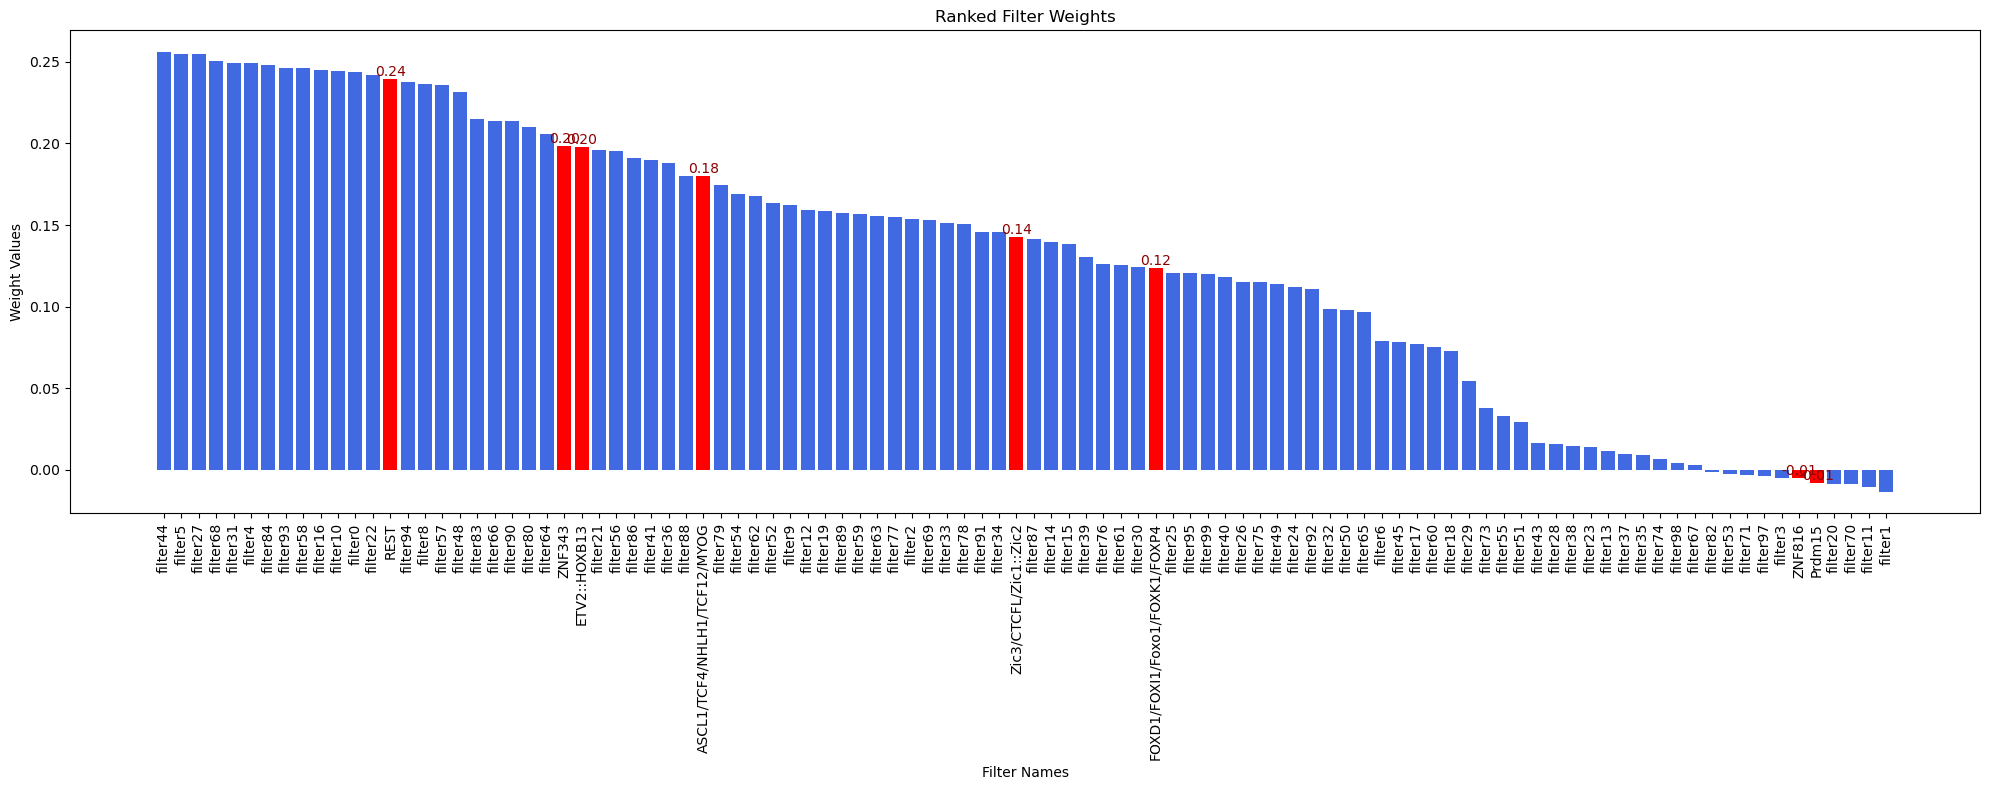

In [7]:
# Set up the figure
# Sort the DataFrame by values in this row, descending order to get the highest weights first
sorted_df = weight_df.loc['weight'].sort_values(ascending=False)

# Extract sorted labels and values for plotting
labels = sorted_df.index
values = sorted_df.values
plt.figure(figsize=(20, 8))  # Adjust size as necessary
colors = ['red' if 'filter' not in label.lower() else 'royalblue' for label in labels]

# Create the bar plot
plt.bar(labels, values, color=colors)

# Label customization
plt.xlabel('Filter Names')
plt.ylabel('Weight Values')
plt.title('Ranked Filter Weights')
plt.xticks(rotation=90)  # Rotate labels to avoid overlap

# Annotating specific bars
for i, label in enumerate(labels):
    if 'filter' not in label.lower():
        plt.text(i, values[i], f'{values[i]:.2f}', ha='center', va='bottom', color='darkred')

# Show the plot
plt.tight_layout()
plt.show()


In [9]:
ann_wdf = weight_df.loc[:,["filter" not in i for i in list(weight_df)]]
ann_wdf

,Prdm15,Zic3/CTCFL/Zic1::Zic2,ZNF343,ASCL1/TCF4/NHLH1/TCF12/MYOG,FOXD1/FOXI1/Foxo1/FOXK1/FOXP4,ETV2::HOXB13,ZNF816,REST
weight,-0.008279,0.142921,0.198733,0.17988,0.123928,0.197742,-0.005274,0.2396


In [10]:
unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
target_labels = ['GFP+ Intensity']
unit_importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, 19, target_labels)


In [13]:
# Assuming 'interpretation' and 'explainn' are already defined and properly configured
# Also assuming 'data_loader', 'device', and 'annotation' are defined as per your setup

unit_importance_values = []
unit_names = []

# Loop through units with indices 0 to 4
for unit_index in range(100):
    filter_key = "filter" + str(unit_index)
    title = annotation[filter_key] if filter_key in annotation.index else filter_key
    unit_names.append(title)  # Store the unit name for plotting
    
    # Calculate unit importance for the current unit
    unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
    target_labels = ['GFP+ Intensity']
    importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, unit_index, target_labels)
    unit_importance_values.append(importance['GFP+ Intensity'])  # Assuming importance for 'GFP+ Intensity' is a list of floats



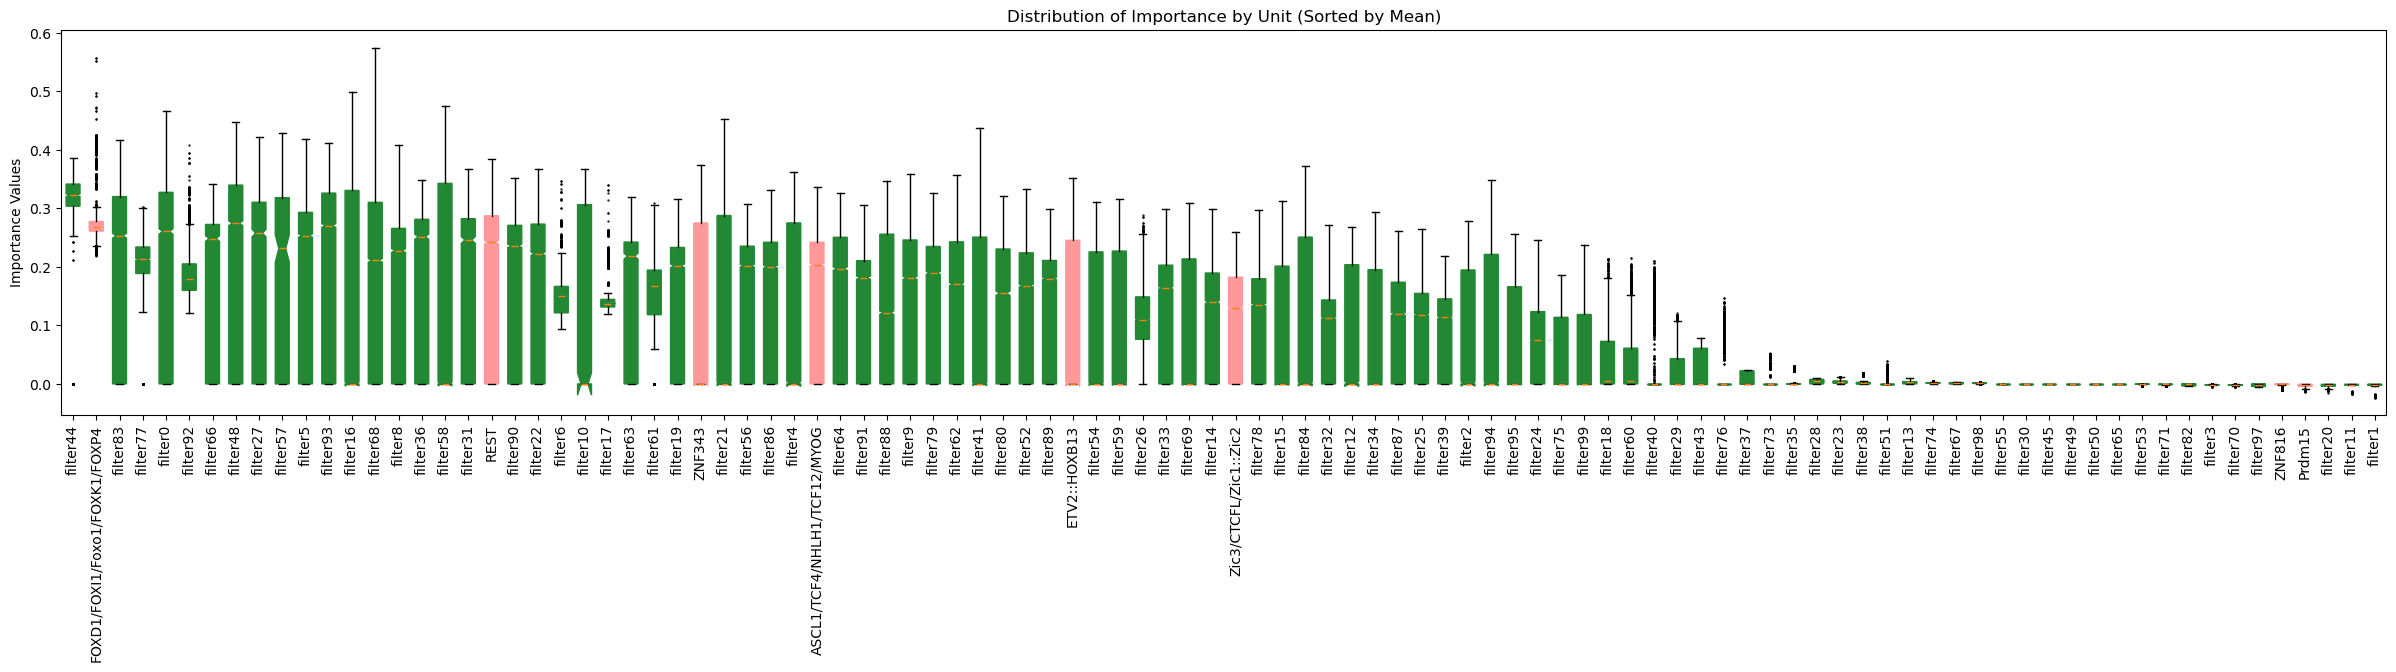

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data: assume these are defined elsewhere in your code
# unit_importance_values = [[0.2, 0.3, 0.5], [0.1, 0.2], [0.5, 0.6, 0.7, 0.5], [0.4, 0.4], [0.1]]
# unit_names = ['Unit1', 'Filter2', 'Unit3', 'Filter4', 'Unit5']

# Calculate the means of each list in unit_importance_values
means = [np.mean(values) for values in unit_importance_values]

# Create tuples of means, unit names, and values, then sort them by means
sorted_data = sorted(zip(means, unit_names, unit_importance_values), key=lambda x: x[0], reverse = True)

# Unzip the sorted data
sorted_means, sorted_names, sorted_values = zip(*sorted_data)

fig, ax = plt.subplots()
flierprops = dict(marker='o', color='black', markersize=0.6)
box_width = 0.6
# Create box plots individually to control colors
for i, (name, data) in enumerate(zip(sorted_names, sorted_values)):
    color = "#ff9999" if "filter" not in name.lower() else "#228833"  # Color differently if 'filter' not in name
    ax.boxplot(data, positions=[i+1], notch=True, widths=box_width, patch_artist=True, boxprops=dict(facecolor=color, color=color),flierprops=flierprops)

ax.set_xticklabels(sorted_names)  # Set custom sorted x-axis labels
ax.set_xticks(range(1, len(sorted_names) + 1))  # Set x-tick positions
fig.set_size_inches(30, 5)
plt.title("Distribution of Importance by Unit (Sorted by Mean)")
plt.ylabel("Importance Values")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()


(100, 19, 4)
(100,)


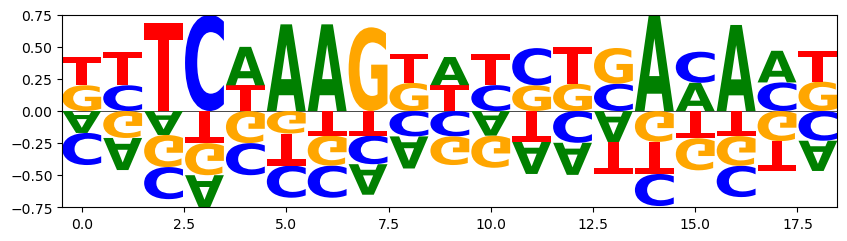

In [12]:
motifs, motif_names = tools.read_meme('/pmglocal/ty2514/Enhancer/Enhancer/data/100CNN_TFBS.meme')
filter_size = 19
print(motifs.shape)
print(motif_names.shape)
filterid=0

x = [list(i) for i in motifs[filterid]]
pwm = tools._PWM_to_filter_weights(x, filter_size)
nn_logo = logomaker.Logo(pd.DataFrame(data=pwm,columns = ["A","C", "G","T"]))

### Motif Clustering Plotting

In [6]:
# Load the similarity matrix
from scipy.cluster.hierarchy import linkage

data = np.load('/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/clustering/similarities.npz')
similarity_matrix = data['similarities']  # adjust the key if different
# Generate the linkage matrix
distance_matrix = 10.0 - similarity_matrix
Z = linkage(distance_matrix, method='complete')
Z.shape

/tmp/ipykernel_2832117/1458146570.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


(99, 4)

/tmp/ipykernel_2832117/1903318857.py:5: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, method='complete')


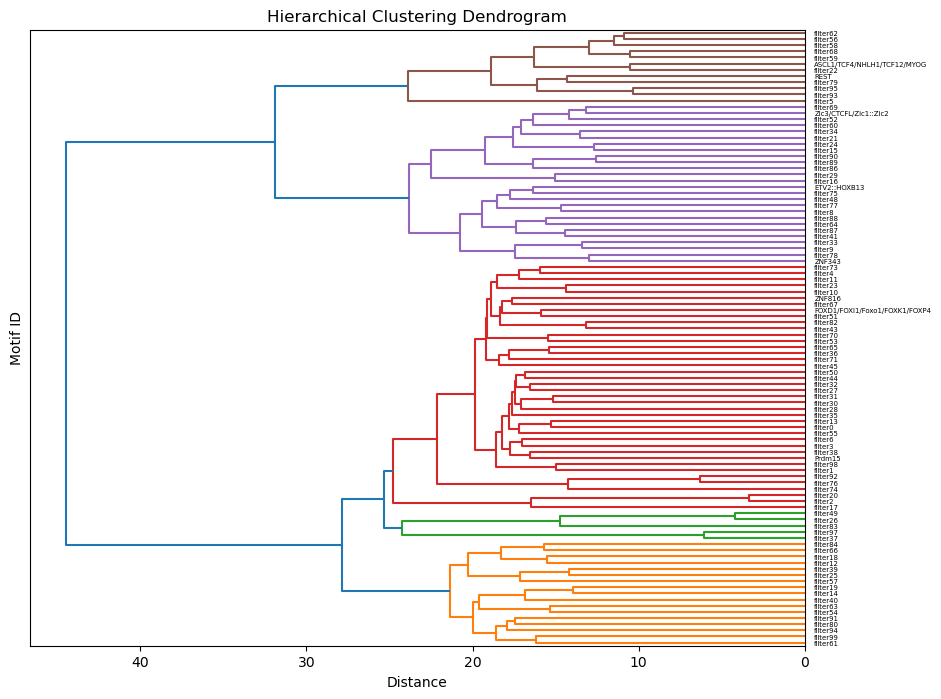

In [36]:
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
# Generate the linkage matrix
distance_matrix = 10.0 - similarity_matrix
Z = linkage(distance_matrix, method='complete')

# Load motif names
clusters = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/clustering/clusters.tsv', sep='\t')
motif_names = clusters['Motif_ID'].values
# Replace motif names with annotated ones if the annotation exists
for i in range(len(motif_names)):
    if motif_names[i] in annotation.keys():
        motif_names[i] = annotation[motif_names[i]]

plt.figure(figsize=(10, 8))
dendrogram(Z, orientation='left', labels=motif_names, color_threshold=25)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Distance')
plt.ylabel('Motif ID')
plt.show()

/tmp/ipykernel_2832117/714316848.py:14: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  Z = linkage(distance_matrix, 'ward')


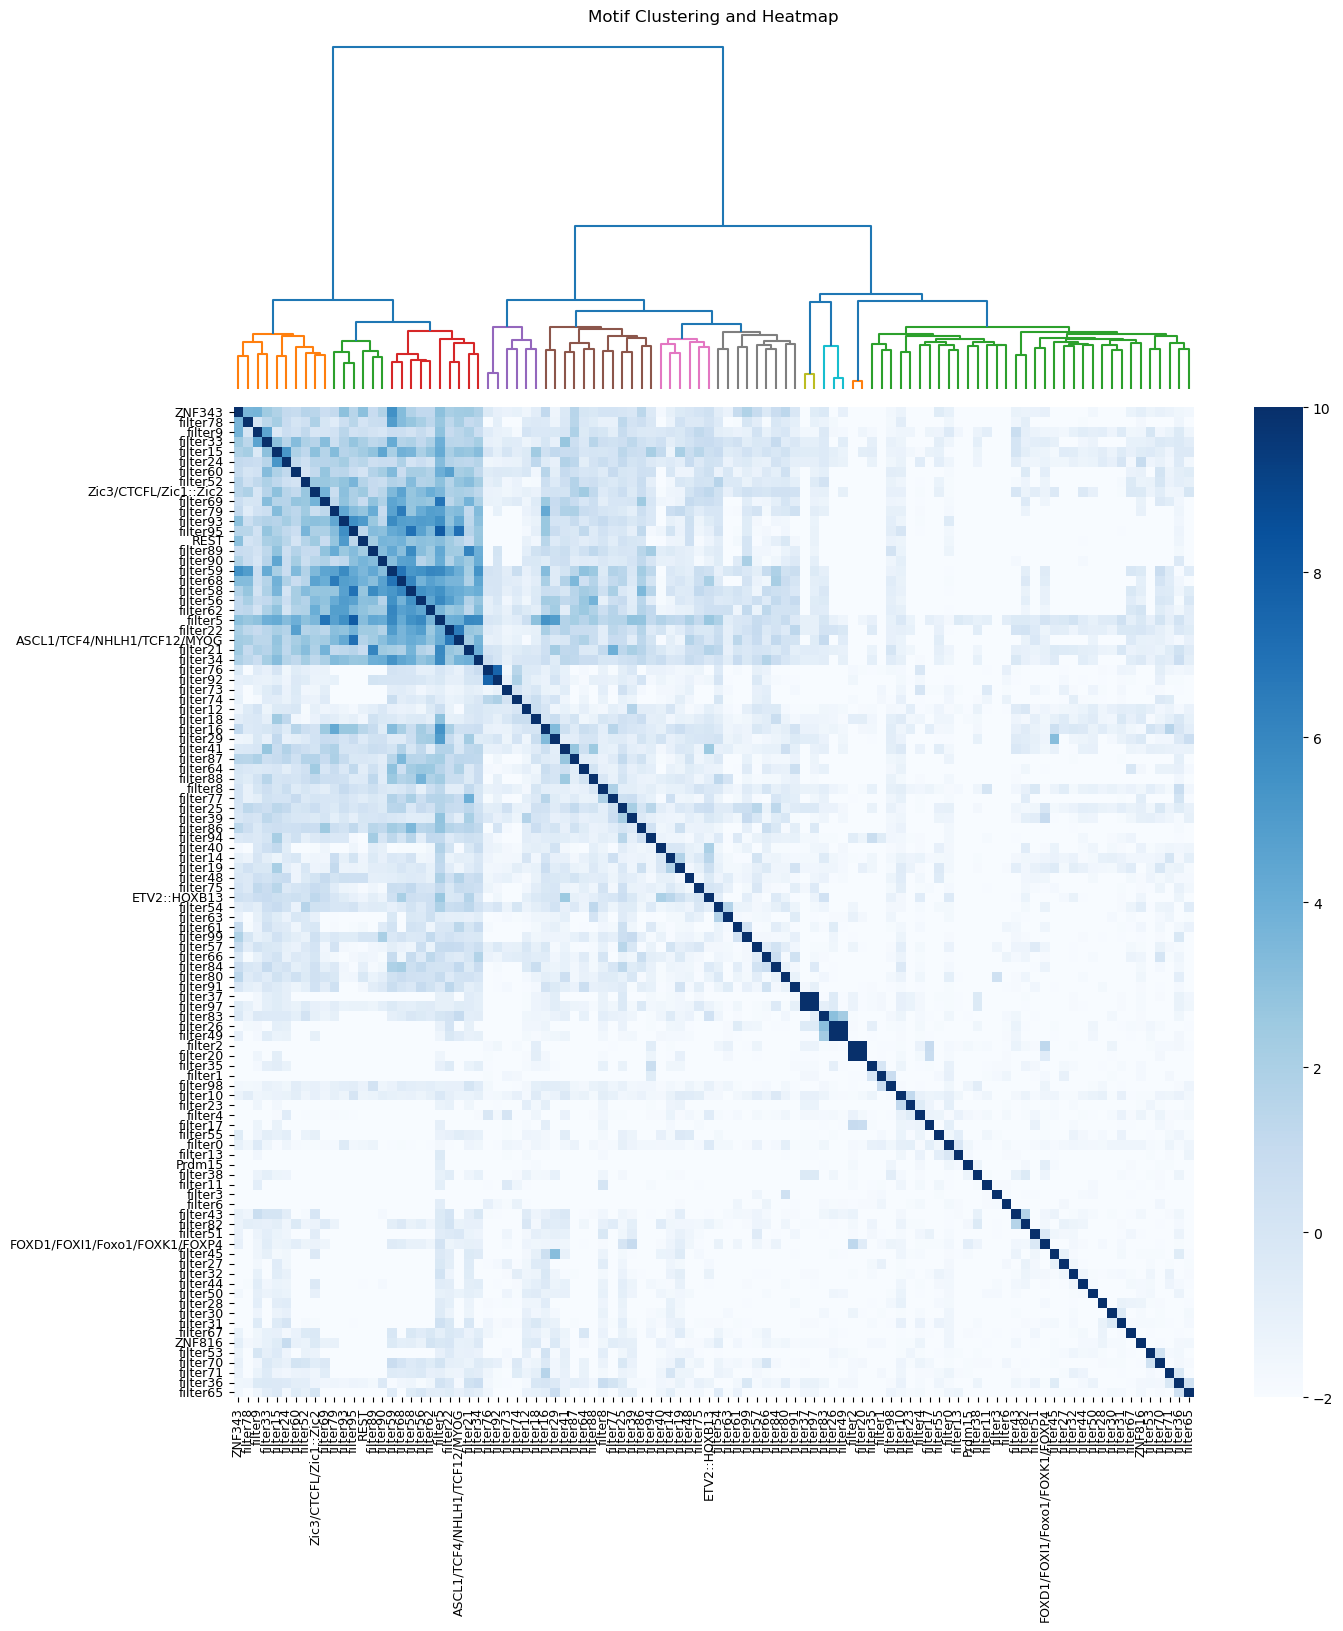

In [33]:
# Load data and process as previously described
clusters = pd.read_csv('/pmglocal/ty2514/Enhancer/Enhancer/tomtom_2024results/clustering/clusters.tsv', sep='\t')
motif_names = clusters['Motif_ID'].values

# Replace motif names with annotated ones if the annotation exists
for i in range(len(motif_names)):
    if motif_names[i] in annotation.keys():
        motif_names[i] = annotation[motif_names[i]]

# Convert similarity to distance
distance_matrix = 10 - similarity_matrix  # Assuming max value in similarity_matrix is 10

# Generate linkage matrix
Z = linkage(distance_matrix, 'ward')

# Prepare figure
fig = plt.figure(figsize=(12, 18))

# Create dendrogram on top
ax1 = fig.add_axes([0.1, 0.66, 0.8, 0.2])  # position: [left, bottom, width, height]
dendro = dendrogram(Z, orientation='top', labels=motif_names, color_threshold=25)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.set_title('Motif Clustering and Heatmap')


# Extract order of leaves after dendrogram
idx = dendro['leaves']

# Reorder data and labels according to dendrogram
data_ordered = similarity_matrix[idx, :][:, idx]
motif_names_ordered = np.array(motif_names)[idx]

# Create heatmap below the dendrogram
ax2 = fig.add_axes([0.1, 0.1, 1, 0.55])  # Match the horizontal positioning with dendrogram
sns.heatmap(data_ordered, ax=ax2, xticklabels=motif_names_ordered, yticklabels=motif_names_ordered, cmap='Blues')
ax2.tick_params(axis='x', rotation=90,labelsize=9)  # Rotate x labels for better visibility
ax2.tick_params(axis='y', labelsize=9)  # Rotate x labels for better visibility

plt.show()
